This is a quick writeup of where I'm at. There are still a lot of issues with the model I'll address below.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *

In [3]:
np.set_printoptions(threshold=50, edgeitems=20)

In [4]:
PATH='data/credit_default_risk/'

In [ ]:
app_test_df = pd.read_csv(f'{PATH}application_test.csv')
app_test_df.head()

In [ ]:
app_train_df = pd.read_csv(f'{PATH}application_train.csv')
app_train_df.head()

In [ ]:
bureau_df = pd.read_csv(f'{PATH}bureau.csv')
bureau_df.head()

In [ ]:
bureau_balance_df = pd.read_csv(f'{PATH}bureau_balance.csv')
bureau_balance_df.head()

In [2]:
pos_cash_df = pd.read_csv(f'{PATH}POS_CASH_balance.csv')
pos_cash_df.head()

In [1]:
credit_card_df = pd.read_csv(f'{PATH}credit_card_balance.csv')
credit_card_df.head()

In [ ]:
pos_cash_df = pd.read_csv(f'{PATH}POS_CASH_balance.csv')
pos_cash_df.head()

In [ ]:
prev_app_df = pd.read_csv(f'{PATH}previous_application.csv')
prev_app_df.head()

In [ ]:
install_df = pd.read_csv(f'{PATH}installments_payments.csv')
install_df.head()

Data processing taken from a [Kaggle kernel](https://www.kaggle.com/shep312/lightgbm-with-weighted-averages-dropout-787/code)

In [ ]:
print('Data loaded.\nMain application training data set shape = {}'.format(app_train_df.shape))
print('Main application test data set shape = {}'.format(app_test_df.shape))
print('Positive target proportion = {:.2f}'.format(app_train_df['TARGET'].mean()))

In [ ]:
def feature_engineering(app_data, bureau_df, bureau_balance_df, credit_card_df,
                        pos_cash_df, prev_app_df, install_df):
    """ 
    Process the input dataframes into a single one containing all the features. Requires
    a lot of aggregating of the supplementary datasets such that they have an entry per
    customer.
    
    Also, add any new features created from the existing ones
    """
    
    # # Add new features
    
    # Amount loaned relative to salary
    app_data['LOAN_INCOME_RATIO'] = app_data['AMT_CREDIT'] / app_data['AMT_INCOME_TOTAL']
    app_data['ANNUITY_INCOME_RATIO'] = app_data['AMT_ANNUITY'] / app_data['AMT_INCOME_TOTAL']
    app_data['ANNUITY LENGTH'] = app_data['AMT_CREDIT'] / app_data['AMT_ANNUITY']
    
    # # Aggregate and merge supplementary datasets
    print('Combined train & test input shape before any merging  = {}'.format(app_data.shape))

    # Previous applications
    agg_funs = {'SK_ID_CURR': 'count', 'AMT_CREDIT': 'sum'}
    prev_apps = prev_app_df.groupby('SK_ID_CURR').agg(agg_funs)
    prev_apps.columns = ['PREV APP COUNT', 'TOTAL PREV LOAN AMT']
    merged_df = app_data.merge(prev_apps, left_on='SK_ID_CURR', right_index=True, how='left')

    # Average the rest of the previous app data
    prev_apps_avg = prev_app_df.groupby('SK_ID_CURR').mean()
    merged_df = merged_df.merge(prev_apps_avg, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_PAVG'])
    print('Shape after merging with previous apps num data = {}'.format(merged_df.shape))
    
    # Previous app categorical features
    prev_app_df, cat_feats, _ = process_dataframe(prev_app_df)
    prev_apps_cat_avg = prev_app_df[cat_feats + ['SK_ID_CURR']].groupby('SK_ID_CURR')\
                             .agg({k: lambda x: str(x.mode().iloc[0]) for k in cat_feats})
    merged_df = merged_df.merge(prev_apps_cat_avg, left_on='SK_ID_CURR', right_index=True,
                            how='left', suffixes=['', '_BAVG'])
    print('Shape after merging with previous apps cat data = {}'.format(merged_df.shape))

    # Credit card data - numerical features
    wm = lambda x: np.average(x, weights=-1/credit_card_df.loc[x.index, 'MONTHS_BALANCE'])
    credit_card_avgs = credit_card_df.groupby('SK_ID_CURR').agg(wm)   
    merged_df = merged_df.merge(credit_card_avgs, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_CCAVG'])
    
    # Credit card data - categorical features
    most_recent_index = credit_card_df.groupby('SK_ID_CURR')['MONTHS_BALANCE'].idxmax()
    cat_feats = credit_card_df.columns[credit_card_df.dtypes == 'object'].tolist()  + ['SK_ID_CURR']
    merged_df = merged_df.merge(credit_card_df.loc[most_recent_index, cat_feats], left_on='SK_ID_CURR', right_on='SK_ID_CURR',
                       how='left', suffixes=['', '_CCAVG'])
    print('Shape after merging with credit card data = {}'.format(merged_df.shape))

    # Credit bureau data - numerical features
    credit_bureau_avgs = bureau_df.groupby('SK_ID_CURR').mean()
    merged_df = merged_df.merge(credit_bureau_avgs, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_BAVG'])
    print('Shape after merging with credit bureau data = {}'.format(merged_df.shape))
    
    # Bureau balance data
    most_recent_index = bureau_balance_df.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmax()
    bureau_balance_df = bureau_balance_df.loc[most_recent_index, :]
    merged_df = merged_df.merge(bureau_balance_df, left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU',
                            how='left', suffixes=['', '_B_B'])
    print('Shape after merging with bureau balance data = {}'.format(merged_df.shape))

    # Pos cash data - weight values by recency when averaging
    wm = lambda x: np.average(x, weights=-1/pos_cash_df.loc[x.index, 'MONTHS_BALANCE'])
    f = {'CNT_INSTALMENT': wm, 'CNT_INSTALMENT_FUTURE': wm, 'SK_DPD': wm, 'SK_DPD_DEF':wm}
    cash_avg = pos_cash_df.groupby('SK_ID_CURR')['CNT_INSTALMENT','CNT_INSTALMENT_FUTURE',
                                                 'SK_DPD', 'SK_DPD_DEF'].agg(f)
    merged_df = merged_df.merge(cash_avg, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_CAVG'])
    
    # Pos cash data data - categorical features
    most_recent_index = pos_cash_df.groupby('SK_ID_CURR')['MONTHS_BALANCE'].idxmax()
    cat_feats = pos_cash_df.columns[pos_cash_df.dtypes == 'object'].tolist()  + ['SK_ID_CURR']
    merged_df = merged_df.merge(pos_cash_df.loc[most_recent_index, cat_feats], left_on='SK_ID_CURR', right_on='SK_ID_CURR',
                       how='left', suffixes=['', '_CAVG'])
    print('Shape after merging with pos cash data = {}'.format(merged_df.shape))

    # Installments data
    ins_avg = install_df.groupby('SK_ID_CURR').mean()
    merged_df = merged_df.merge(ins_avg, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_IAVG'])
    print('Shape after merging with installments data = {}'.format(merged_df.shape))
    
    # Add more value counts
    merged_df = merged_df.merge(pd.DataFrame(bureau_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_BUREAU'])
    merged_df = merged_df.merge(pd.DataFrame(credit_card_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_CRED_CARD'])
    merged_df = merged_df.merge(pd.DataFrame(pos_cash_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_POS_CASH'])
    merged_df = merged_df.merge(pd.DataFrame(install_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_INSTALL'])
    print('Shape after merging with counts data = {}'.format(merged_df.shape))

    return merged_df

In [5]:
def process_dataframe(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """

    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    categorical_feats = categorical_feats
    encoder_dict = {}
    for feat in categorical_feats:
#         encoder = LabelEncoder()
        input_df[feat] = input_df[feat].fillna('NULL')
#         input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
#         encoder_dict[feat] = encoder

    return input_df, categorical_feats.tolist(), encoder_dict

In [ ]:
merged_df.to_feather(f'{PATH}merged_df')

In [6]:
merged_df = pd.read_feather(f'{PATH}merged_df')

In [7]:
merged_df.columns

Index(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       ...
       'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT',
       'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT',
       'SK_ID_CURR_CNT_BUREAU', 'SK_ID_CURR_CNT_CRED_CARD',
       'SK_ID_CURR_CNT_POS_CASH', 'SK_ID_CURR_CNT_INSTALL'],
      dtype='object', length=216)

In [8]:
cols = list(merged_df.columns)

In [9]:
merged_df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105,8.0,NaN,19.0,19.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000,4.0,NaN,28.0,25.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000,2.0,NaN,4.0,3.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438,NaN,6.0,21.0,16.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227,1.0,NaN,66.0,66.0


In [10]:
# Separate metadata
meta_cols = ['SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV']
meta_df = merged_df[meta_cols]
merged_df.drop(meta_cols, axis=1, inplace=True)

In [12]:
# Process the data set.
merged_df, categorical_feats, encoder_dict = process_dataframe(input_df=merged_df)

In [13]:
# Capture other categorical features not as object data types:
non_obj_categoricals = [
    'FONDKAPREMONT_MODE',
    'HOUR_APPR_PROCESS_START',
    'HOUSETYPE_MODE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 
    'NAME_HOUSING_TYPE',
    'NAME_INCOME_TYPE', 
    'NAME_TYPE_SUITE', 
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE', 
    'WALLSMATERIAL_MODE',
    'WEEKDAY_APPR_PROCESS_START', 
    'NAME_CONTRACT_TYPE_BAVG',
    'WEEKDAY_APPR_PROCESS_START_BAVG',
    'NAME_CASH_LOAN_PURPOSE', 
    'NAME_CONTRACT_STATUS', 
    'NAME_PAYMENT_TYPE',
    'CODE_REJECT_REASON', 
    'NAME_TYPE_SUITE_BAVG', 
    'NAME_CLIENT_TYPE',
    'NAME_GOODS_CATEGORY', 
    'NAME_PORTFOLIO', 
    'NAME_PRODUCT_TYPE',
    'CHANNEL_TYPE', 
    'NAME_SELLER_INDUSTRY', 
    'NAME_YIELD_GROUP',
    'PRODUCT_COMBINATION', 
    'NAME_CONTRACT_STATUS_CCAVG', 
    'STATUS',
    'NAME_CONTRACT_STATUS_CAVG'
]
categorical_feats = categorical_feats + non_obj_categoricals

In [14]:
null_counts = merged_df.isnull().sum()
null_counts = null_counts[null_counts > 0]
null_ratios = null_counts / len(merged_df)

# Drop columns over x% null
null_thresh = .8
null_cols = null_ratios[null_ratios > null_thresh].index
merged_df.drop(null_cols, axis=1, inplace=True)
print('Columns dropped for being over {}% null:'.format(100*null_thresh))
for col in null_cols:
    print(col)
    if col in categorical_feats:
        categorical_feats.pop(col)
    
# Fill the rest with the mean (TODO: do something better!)
# merged_df.fillna(merged_df.median(), inplace=True)
merged_df.fillna(0, inplace=True)

Columns dropped for being over 80.0% null:
RATE_INTEREST_PRIMARY
RATE_INTEREST_PRIVILEGED
AMT_DRAWINGS_ATM_CURRENT
AMT_DRAWINGS_OTHER_CURRENT
AMT_DRAWINGS_POS_CURRENT
AMT_INST_MIN_REGULARITY
AMT_PAYMENT_CURRENT
CNT_DRAWINGS_ATM_CURRENT
CNT_DRAWINGS_OTHER_CURRENT
CNT_DRAWINGS_POS_CURRENT
CNT_INSTALMENT_MATURE_CUM
MONTHS_BALANCE_B_B


In [15]:
merged_df.columns

Index(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       ...
       'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT',
       'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT',
       'SK_ID_CURR_CNT_BUREAU', 'SK_ID_CURR_CNT_CRED_CARD',
       'SK_ID_CURR_CNT_POS_CASH', 'SK_ID_CURR_CNT_INSTALL'],
      dtype='object', length=201)

In [16]:
cont_feats = [x for x in merged_df.columns[~merged_df.columns.isin(categorical_feats)]]

In [17]:
cat_vars = list(categorical_feats)
contin_vars = list(cont_feats)

In [18]:
joined = pd.DataFrame()

In [19]:
for v in cat_vars: joined[v] = merged_df[v].astype('category').cat.as_ordered()

In [20]:
for v in contin_vars: joined[v] = merged_df[v].fillna(0).astype('float32')

In [21]:
joined.head()

,CODE_GENDER,EMERGENCYSTATE_MODE,FLAG_OWN_CAR,FLAG_OWN_REALTY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR_CNT_BUREAU,SK_ID_CURR_CNT_CRED_CARD,SK_ID_CURR_CNT_POS_CASH,SK_ID_CURR_CNT_INSTALL
0,M,No,N,Y,reg oper account,block of flats,Cash loans,Secondary / secondary special,Single / not married,House / apartment,...,1.052632,10.000000,-295.000000,-315.421051,11559.247070,11559.247070,8.0,0.0,19.0,19.0
1,F,No,N,N,reg oper account,block of flats,Cash loans,Higher education,Married,House / apartment,...,1.040000,5.080000,-1378.160034,-1385.319946,64754.585938,64754.585938,4.0,0.0,28.0,25.0
2,M,NULL,Y,Y,NULL,NULL,Revolving loans,Secondary / secondary special,Single / not married,House / apartment,...,1.333333,2.000000,-754.000000,-761.666687,7096.154785,7096.154785,2.0,0.0,4.0,3.0
3,F,NULL,N,Y,NULL,NULL,Cash loans,Secondary / secondary special,Civil marriage,House / apartment,...,1.125000,4.437500,-252.250000,-271.625000,62947.089844,62947.089844,0.0,6.0,21.0,16.0
4,M,NULL,N,Y,NULL,NULL,Cash loans,Secondary / secondary special,Single / not married,House / apartment,...,1.166667,7.045455,-1028.606079,-1032.242432,12666.444336,12214.060547,1.0,0.0,66.0,66.0


In [22]:
from torch.nn import functional as F

Modified fastai classes taken from a notebook by [Kerem Turgutlu](https://github.com/KeremTurgutlu/deeplearning/blob/master/avazu/FAST.AI%20Classification%20-%20Kaggle%20Avazu%20CTR.ipynb)

In [23]:
class  MixedInputModelMixedIn (nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x

In [24]:
class ColumnarDataset(Dataset):
    def __init__(self, cats, conts, y):
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y #y.values # THIS LINE IS CHANGED FROM y[:, None]
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

    @classmethod
    def from_data_frames(cls, df_cat, df_cont, y=None):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y)

    @classmethod
    def from_data_frame(cls, df, cat_flds, y=None):
        return cls.from_data_frames(df[cat_flds], df.drop(cat_flds, axis=1), y)

In [25]:
class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs)) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y), PassthruDataset(*(val_xs.T), val_y),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)

In [26]:
joined_train_all = joined[:307511]
joined_test = joined[307511:]

In [27]:
df, y, nas, mapper = proc_df(joined_train_all, 'TARGET', do_scale=True)

c:\users\gateway\anaconda2\envs\tensorflow-gpu\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [28]:
df_test, _, nas, mapper = proc_df(joined_test, 'TARGET', do_scale=True, mapper=mapper, na_dict=nas)

c:\users\gateway\anaconda2\envs\tensorflow-gpu\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [29]:
n = len(df)
val_idx = get_cv_idxs(n)

In [30]:
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('CODE_GENDER', 4),
 ('EMERGENCYSTATE_MODE', 4),
 ('FLAG_OWN_CAR', 3),
 ('FLAG_OWN_REALTY', 3),
 ('FONDKAPREMONT_MODE', 6),
 ('HOUSETYPE_MODE', 5),
 ('NAME_CONTRACT_TYPE', 3),
 ('NAME_EDUCATION_TYPE', 6),
 ('NAME_FAMILY_STATUS', 7),
 ('NAME_HOUSING_TYPE', 7),
 ('NAME_INCOME_TYPE', 9),
 ('NAME_TYPE_SUITE', 9),
 ('OCCUPATION_TYPE', 20),
 ('ORGANIZATION_TYPE', 59),
 ('WALLSMATERIAL_MODE', 9),
 ('WEEKDAY_APPR_PROCESS_START', 8),
 ('NAME_CONTRACT_TYPE_BAVG', 6),
 ('WEEKDAY_APPR_PROCESS_START_BAVG', 9),
 ('FLAG_LAST_APPL_PER_CONTRACT', 4),
 ('NAME_CASH_LOAN_PURPOSE', 27),
 ('NAME_CONTRACT_STATUS', 6),
 ('NAME_PAYMENT_TYPE', 6),
 ('CODE_REJECT_REASON', 11),
 ('NAME_TYPE_SUITE_BAVG', 10),
 ('NAME_CLIENT_TYPE', 6),
 ('NAME_GOODS_CATEGORY', 28),
 ('NAME_PORTFOLIO', 7),
 ('NAME_PRODUCT_TYPE', 5),
 ('CHANNEL_TYPE', 10),
 ('NAME_SELLER_INDUSTRY', 13),
 ('NAME_YIELD_GROUP', 7),
 ('PRODUCT_COMBINATION', 20),
 ('NAME_CONTRACT_STATUS_CCAVG', 6),
 ('STATUS', 10),
 ('NAME_CONTRACT_STATUS_CAVG', 9),
 ('F

In [31]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(4, 2),
 (4, 2),
 (3, 2),
 (3, 2),
 (6, 3),
 (5, 3),
 (3, 2),
 (6, 3),
 (7, 4),
 (7, 4),
 (9, 5),
 (9, 5),
 (20, 10),
 (59, 30),
 (9, 5),
 (8, 4),
 (6, 3),
 (9, 5),
 (4, 2),
 (27, 14),
 (6, 3),
 (6, 3),
 (11, 6),
 (10, 5),
 (6, 3),
 (28, 14),
 (7, 4),
 (5, 3),
 (10, 5),
 (13, 7),
 (7, 4),
 (20, 10),
 (6, 3),
 (10, 5),
 (9, 5),
 (6, 3),
 (25, 13),
 (5, 3),
 (6, 3),
 (7, 4),
 (7, 4),
 (9, 5),
 (9, 5),
 (20, 10),
 (59, 30),
 (9, 5),
 (8, 4),
 (6, 3),
 (9, 5),
 (27, 14),
 (6, 3),
 (6, 3),
 (11, 6),
 (10, 5),
 (6, 3),
 (28, 14),
 (7, 4),
 (5, 3),
 (10, 5),
 (13, 7),
 (7, 4),
 (20, 10),
 (6, 3),
 (10, 5),
 (9, 5)]

In [32]:
model = MixedInputModel(emb_szs, n_cont=164, emb_drop=0.1, out_sz=2, szs=[1024, 512], drops=[0.2, 0.2], use_bn=True).cuda()

In [33]:
bm = BasicModel(model, 'binary_calssifier')

In [34]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=128)

In [35]:
class StructuredLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss

In [50]:
learn = StructuredLearner(md, bm)

In [51]:
learn.crit = F.cross_entropy

In [52]:
learn.crit

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

In [39]:
learn.lr_find()

 88%|██████████████████████████████████████████████████████████▊        | 1688/1922 [00:29<00:04, 58.04it/s, loss=80.5]

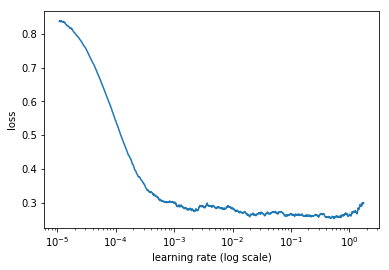

 88%|██████████████████████████████████████████████████████████▊        | 1688/1922 [00:40<00:05, 42.19it/s, loss=80.5]

In [40]:
learn.sched.plot()


In [41]:
from sklearn.metrics import roc_auc_score

def roc_val(probs, y):
    probs = np.exp(probs[:,1])
    return roc_auc_score(y, probs)

In [42]:
torch.cuda.set_device(0)
torch.cuda.is_available()

True

In [43]:
torch.backends.cudnn.enabled

True

In [53]:
lr = 1e-3
learn.fit(lr, 4, metrics=[roc_val], cycle_len=2)


epoch      trn_loss   val_loss   roc_val                                                                               
    0      0.266992   0.263428   0.690083  
    1      0.269895   0.261943   0.695717                                                                              
    2      0.261076   0.257372   0.711803                                                                              
    3      0.25985    0.256717   0.714264                                                                              
    4      0.263147   0.254646   0.722195                                                                              
    5      0.261516   0.25429    0.723518                                                                              
    6      0.26009    0.253153   0.727861                                                                              
    7      0.25783    0.25294    0.728926                                                                           

[0.2529396504945846, 0.7289258719846072]

epoch      trn_loss   val_loss                                                                                         
    0      0.258201   0.25425   


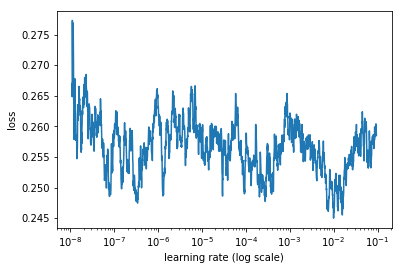

In [54]:
learn.lr_find(start_lr=1e-8,end_lr=1e-1)
learn.sched.plot()

In [55]:
learn.fit(5e-4, 5, metrics=[roc_val], cycle_len=1)

epoch      trn_loss   val_loss   roc_val                                                                               
    0      0.254022   0.252717   0.73005   
    1      0.246642   0.252504   0.730816                                                                              
    2      0.258807   0.25227    0.731804                                                                              
    3      0.242717   0.252103   0.732654                                                                              
    4      0.261061   0.25192    0.73318                                                                               


[0.25191987562922324, 0.7331795781757375]

In [56]:
learn.fit(5e-4, 2, metrics=[roc_val], cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   roc_val                                                                               
    0      0.260467   0.251779   0.73374   
    1      0.254735   0.251558   0.734617                                                                              
    2      0.25296    0.251512   0.734919                                                                              


[0.25151206315879854, 0.7349193426039092]

In [59]:
log_preds = learn.predict()

In [60]:
log_preds.shape

(61502, 2)

In [61]:
preds = np.argmax(log_preds, axis=1) 

In [65]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [66]:
pd.Series(preds).value_counts()

0    61500
1        2
dtype: int64

In [74]:
expsums = np.exp(log_preds).sum(axis=1)
probs = np.exp(log_preds) / expsums[:,None]

In [75]:
probs[:10]

array([[0.72726, 0.27274],
       [0.96198, 0.03802],
       [0.99121, 0.00879],
       [0.98227, 0.01773],
       [0.96817, 0.03183],
       [0.73551, 0.26449],
       [0.88413, 0.11587],
       [0.96194, 0.03806],
       [0.91709, 0.08291],
       [0.92594, 0.07406]], dtype=float32)

In [76]:
np.max(probs[:,1])

0.53723186

In [174]:
out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][307511:], 'TARGET':probs[:,1]})

In [175]:
out_df.head()

,SK_ID_CURR,TARGET
307511,100001,0.030374
307512,100005,0.170553
307513,100013,0.029460
307514,100028,0.041638
307515,100038,0.213112


In [176]:
out_df.to_csv('credit_default_submission.csv', index=False)

## Issues with the model
As you can see in training the cross entropy loss doesn't really change. The ROC score improves with training, but usually maxes out around 0.76. I think one issue is that the training dataset is 92% 0s. I think the model might be learning that it can be mostly right by always outputting a low probability.